In [1]:
import numpy as np
import pandas as pd
import zipfile
import dask.dataframe as dk
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import mixed_precision
import gc

# Bật mixed precision
mixed_precision.set_global_policy('mixed_float16')
tf.get_logger().setLevel('ERROR')
tf.config.optimizer.set_jit(True)  # Bật XLA để tối ưu hóa

# Cấu hình Dask Client với giới hạn tài nguyên (12GB RAM)
from dask.distributed import Client
client = Client(n_workers=2, threads_per_worker=2, memory_limit='4GB')
print(client)

input_files = [f"file{i+1}" for i in range(3)]
temp_dir = "FL_Data/"
input_files = [temp_dir + output_file for output_file in input_files]
print(input_files)

# Đọc dữ liệu Parquet với Dask, chỉ lấy metadata để giảm tải
df = [dk.read_parquet(file, columns=None) for file in input_files]  # Chỉ đọc metadata
print(df[1].dtypes)

batch_size = 512  # Tăng batch_size để giảm số bước
ratio_test_all = 0.2
features_len = len(df[0].columns) - 1  # Giả định tất cả file có cùng cấu trúc
print("Feature Len:", features_len)

# Ước lượng số lượng mẫu từ metadata thay vì tính chính xác
train_sizes = [df_i.shape[0].compute() * (1 - ratio_test_all) for df_i in df]
val_sizes = [df_i.shape[0].compute() * ratio_test_all * 0.25 for df_i in df]
test_sizes = [df_i.shape[0].compute() * ratio_test_all * 0.75 for df_i in df]

train_dfs = []
val_dfs = []
test_dfs = []
for dff in df:
    train_df, val_test_df = dff.random_split([1 - ratio_test_all, ratio_test_all], shuffle=True)
    test_df, val_df = val_test_df.random_split([0.75, 0.25], shuffle=True)
    train_dfs.append(train_df)
    val_dfs.append(val_df)
    test_dfs.append(test_df)

def dask_to_tf_dataset(dask_df, batch_size, features_len):
    def generator():
        for batch in dask_df.to_delayed():
            batch = batch.compute()
            if batch.empty:
                continue
            X = batch.drop(columns=['label']).values.astype(np.float32)
            y = batch['label'].values.astype(np.int32)
            num_splits = max(1, len(X) // batch_size)
            X_batches = np.array_split(X, num_splits)
            y_batches = np.array_split(y, num_splits)
            for X_batch, y_batch in zip(X_batches, y_batches):
                yield X_batch, y_batch
    output_signature = (
        tf.TensorSpec(shape=(None, features_len), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32),
    )
    dataset = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
    return dataset.cache().prefetch(tf.data.AUTOTUNE).shuffle(buffer_size=1000)

train_gens = [dask_to_tf_dataset(train_df, batch_size, features_len).repeat() for train_df in train_dfs]
val_gens = [dask_to_tf_dataset(val_df, batch_size, features_len).repeat() for val_df in val_dfs]
test_gens = [dask_to_tf_dataset(test_df, batch_size, features_len).repeat() for test_df in test_dfs]

from server_multi import Server
from client_multi import Client
import datetime

num_servers = 1
num_clients = 3

# Ước lượng steps
stepsPerEpoch_Clients = [int(np.ceil(size / batch_size)) for size in train_sizes]
stepsValidate_Clients = [int(np.ceil(size / batch_size)) for size in val_sizes]
stepsTest_Clients = [int(np.ceil(size / batch_size)) for size in test_sizes]

active_servers_list = ['server_' + str(i) for i in range(num_servers)]
active_clients_list = ['client_' + str(i) for i in range(num_clients)]
print(active_servers_list)
print(active_clients_list)

agents_dict = {}
serverObjects = {server_name: Server(server_name=server_name, active_clients_list=active_clients_list)
                 for server_name in active_servers_list}

clientObjects = {client_name: Client(client_name, train_gens[clientID], val_gens[clientID], test_gens[clientID],
                                     stepsPerEpoch_Clients[clientID], stepsValidate_Clients[clientID], stepsTest_Clients[clientID],
                                     active_clients_list=active_clients_list)
                 for clientID, client_name in enumerate(active_clients_list)}

temp_dir_log = clientObjects['client_0'].get_temp_dir()
for index, client_name in enumerate(active_clients_list):
    clientObjects[client_name].get_steps_per_epoch()
    clientObjects[client_name].get_validation_steps()
    clientObjects[client_name].get_test_steps()

agents_dict['server'] = serverObjects
agents_dict['client'] = clientObjects

for agent_name, agent in serverObjects.items():
    agent.set_agentsDict(agents_dict=agents_dict)
for agent_name, agent in clientObjects.items():
    agent.set_agentsDict(agents_dict=agents_dict)

# Giải phóng tài nguyên không cần thiết
del train_dfs, val_dfs, test_dfs, df
gc.collect()

server = agents_dict['server']['server_0']
if __name__ == '__main__':
    server.InitLoop()
    server.final_statistics()
    client.close()  # Đóng Dask Client sau khi hoàn tất

2025-06-24 12:18:08.892710: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-24 12:18:08.936298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750742288.966288   48243 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750742288.975495   48243 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750742289.011902   48243 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

<Client: 'tcp://127.0.0.1:37615' processes=2 threads=4, memory=7.45 GiB>
['FL_Data/file1', 'FL_Data/file2', 'FL_Data/file3']
flow_duration      float64
Header_Length      float64
Protocol Type      float64
Duration           float64
Rate               float64
Srate              float64
Drate              float64
fin_flag_number    float64
syn_flag_number    float64
rst_flag_number    float64
psh_flag_number    float64
ack_flag_number    float64
ece_flag_number    float64
cwr_flag_number    float64
ack_count          float64
syn_count          float64
fin_count          float64
urg_count          float64
rst_count          float64
HTTP               float64
HTTPS              float64
DNS                float64
Telnet             float64
SMTP               float64
SSH                float64
IRC                float64
TCP                float64
UDP                float64
DHCP               float64
ARP                float64
ICMP               float64
IPv                float64
LLC        

I0000 00:00:1750742296.084770   48243 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


['server_0']
['client_0', 'client_1', 'client_2']
Train steps: 5338
Val steps: 334
Test steps: 1001
Train steps: 3739
Val steps: 234
Test steps: 702
Train steps: 4262
Val steps: 267
Test steps: 800
====================================== Đang chạy Iteration 1 ======================================


I0000 00:00:1750742299.791817   48343 service.cc:152] XLA service 0x7f0b88015430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750742299.791875   48343 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
I0000 00:00:1750742299.807948   48343 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750742299.935482   48343 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-06-24 12:18:24.173094: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


4481/5338 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8976 - loss: 0.2885

2025-06-24 12:18:58.276968: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 12:18:58.377964: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads

2025-06-24 12:18:58.394408: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads



4764/5338 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8997 - loss: 0.2819

2025-06-24 12:18:59.875277: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads

2025-06-24 12:19:00.043891: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads



4809/5338 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9000 - loss: 0.2809

2025-06-24 12:19:00.134491: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads



5022/5338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9015 - loss: 0.2764

2025-06-24 12:19:01.144480: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 12:19:01.344738: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads



5163/5338 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9024 - loss: 0.2735

2025-06-24 12:19:01.913426: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads

2025-06-24 12:19:01.961402: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads



5209/5338 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9027 - loss: 0.2726

2025-06-24 12:19:02.167240: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 292 bytes spill stores, 292 bytes spill loads

2025-06-24 12:19:02.230942: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads



5331/5338 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9035 - loss: 0.2703

2025-06-24 12:19:03.699355: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 12:19:03.205126: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads

2025-06-24 12:19:03.376491: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 12:19:03.613750: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads

2025-06-24 12:19:03.892455: I external

5338/5338 ━━━━━━━━━━━━━━━━━━━━ 88s 15ms/step - accuracy: 0.9035 - loss: 0.2702 - val_accuracy: 0.9510 - val_loss: 0.1198


/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Done model fit



2025-06-24 12:19:46.110217: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads



client_0 End Produce Weights


2025-06-24 12:19:46.480794: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads

2025-06-24 12:19:46.835449: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads



4262/4262 ━━━━━━━━━━━━━━━━━━━━ 90s 19ms/step - accuracy: 0.9043 - loss: 0.2726 - val_accuracy: 0.9510 - val_loss: 0.1228
Done model fit

client_2 End Produce Weights
3739/3739 ━━━━━━━━━━━━━━━━━━━━ 91s 22ms/step - accuracy: 0.9048 - loss: 0.2696 - val_accuracy: 0.9478 - val_loss: 0.1284
Done model fit

client_1 End Produce Weights
Đã lưu global model cho iteration 1 tại multiclass_FL_log/Month06-Day24-12h-18p/client_1_log/global_model_iter_1.keras
Đã lưu global model cho iteration 1 tại multiclass_FL_log/Month06-Day24-12h-18p/client_0_log/global_model_iter_1.keras
Đã lưu global model cho iteration 1 tại multiclass_FL_log/Month06-Day24-12h-18p/client_2_log/global_model_iter_1.keras
  1/702 ━━━━━━━━━━━━━━━━━━━━ 54:09 5s/step - accuracy: 0.9455 - loss: 0.1105

2025-06-24 12:19:53.829069: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads

2025-06-24 12:19:53.973837: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads



  2/702 ━━━━━━━━━━━━━━━━━━━━ 11:40 1s/step - accuracy: 0.9494 - loss: 0.1092

2025-06-24 12:19:54.480921: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads



   1/1001 ━━━━━━━━━━━━━━━━━━━━ 1:42:34 6s/step - accuracy: 0.9475 - loss: 0.1360

2025-06-24 12:19:54.963369: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-24 12:19:55.070152: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


   4/1001 ━━━━━━━━━━━━━━━━━━━━ 8:30 512ms/step - accuracy: 0.9495 - loss: 0.1268

2025-06-24 12:19:56.388787: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads

2025-06-24 12:19:56.773236: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 12:19:56.841749: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads



   5/1001 ━━━━━━━━━━━━━━━━━━━━ 10:27 630ms/step - accuracy: 0.9504 - loss: 0.1248

2025-06-24 12:19:57.592819: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 12:19:57.689191: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads

2025-06-24 12:19:57.790121: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads

2025-06-24 12:19:58.203606: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-24 12:19:58.309605: E external/local

   6/1001 ━━━━━━━━━━━━━━━━━━━━ 11:25 689ms/step - accuracy: 0.9507 - loss: 0.1240

2025-06-24 12:19:58.657433: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-24 12:19:58.742210: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-24 12:19:58.823288: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-24 12:19:58.906757: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-24 12:19:58.989342: E external/local_xla/xla/stream_

   7/1001 ━━━━━━━━━━━━━━━━━━━━ 12:02 727ms/step - accuracy: 0.9509 - loss: 0.1235

2025-06-24 12:19:59.155750: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-24 12:19:59.239260: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-24 12:19:59.328001: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


   9/1001 ━━━━━━━━━━━━━━━━━━━━ 9:13 558ms/step - accuracy: 0.9512 - loss: 0.1237 

2025-06-24 12:19:59.371031: W external/local_xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1369] AutotunerUtil::AddResult already existed: <key model='CUDA: 8.9, Cores: 20, GPU clock: 2.055 GHz, Memory bandwidth: 192 GB/s, L2 cache: 24 MB', hlo='{
  tmp_0 = f32[704,128]{1,0} parameter(1)
  tmp_1 = f16[704,128]{1,0} convert(f32[704,128]{1,0} tmp_0)
  tmp_2 = f16[519,1,11,64]{3,2,1,0} parameter(0)
  tmp_3 = f16[519,704]{1,0} bitcast(f16[519,1,11,64]{3,2,1,0} tmp_2)
  tmp_4 = f16[128,519]{0,1} dot(f16[704,128]{1,0} tmp_1, f16[519,704]{1,0} tmp_3), lhs_contracting_dims={0}, rhs_contracting_dims={1}
  ROOT tmp_5 = f16[519,128]{1,0} bitcast(f16[128,519]{0,1} tmp_4)
}'>
2025-06-24 12:19:59.448327: W external/local_xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1369] AutotunerUtil::AddResult already existed: <key model='CUDA: 8.9, Cores: 20, GPU clock: 2.055 GHz, Memory bandwidth: 192 GB/s, L2 cache: 24 MB', hlo='{
  tmp_0 = f16[519,128]{1,0} parameter(0)
  tmp_1 = f32[128,5

702/702 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9477 - loss: 0.1269
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.9504 - loss: 0.1204
800/800 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.9512 - loss: 0.1231
702/702 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5392 - loss: 1.0179
 13/800 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7077 - loss: 0.9951 Arguments:  Performance Metrics for client_1 on iteration 1 
------------------------------------------- 
local accuracy: 0.9477968215942383 
local loss: 0.12712232768535614 
global accuracy: 0.539479672908783 
global_loss: 1.0179705619812012 
local compute time: 0:01:31.348994 
Simulated time to receive global weights: 0:01:31.510142 
 

1001/1001 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5207 - loss: 0.9539
Arguments:  Performance Metrics for client_0 on iteration 1 
------------------------------------------- 
local accuracy: 0.9505595564842224 
local loss: 0.12002436071634293 
global accuracy: 0.52049

In [2]:
from tensorflow.keras.models import load_model

#tempdirs = [f"federated_learning_log/Month05-Day27-18h-56p/client_{i}_log/" for i in range(len(active_clients_list))]
tempdirs = [temp_dir_log + f"/client_{i}_log/" for i in range(len(active_clients_list))]

model_names =[f"global_model_iter_{i+1}.keras" for i in range(5)]
print(model_names)
models = {}

for i, client_name in enumerate(active_clients_list):
    models[client_name] = [load_model(tempdirs[i]+model_name) for model_name in model_names]
print (models['client_0'])


['global_model_iter_1.keras', 'global_model_iter_2.keras', 'global_model_iter_3.keras', 'global_model_iter_4.keras', 'global_model_iter_5.keras']


/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 34 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


[<Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>]


2025-06-24 13:39:17.640884: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


518647
<Sequential name=sequential, built=True>
16205/16208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-06-24 13:39:34.856610: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 12 bytes spill stores, 12 bytes spill loads

2025-06-24 13:39:34.969205: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 272 bytes spill stores, 272 bytes spill loads

2025-06-24 13:39:35.114771: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 16 bytes spill stores, 16 bytes spill loads

2025-06-24 13:39:35.216174: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 384 bytes spill stores, 384 bytes spill loads



16208/16208 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
<Sequential name=sequential, built=True>
16208/16208 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
<Sequential name=sequential, built=True>
16208/16208 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
<Sequential name=sequential, built=True>
16208/16208 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
<Sequential name=sequential, built=True>
16208/16208 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
Precision Score:  [0.4178175609642193, 0.8874847239200744, 0.8941821657926277, 0.89284081993383, 0.8955884466406967]
Recall Score:  [0.2775217801183302, 0.8194536476755513, 0.8267961060706668, 0.8337875846365403, 0.8366134382187107]
F1 Score:  [0.26291302257161625, 0.842167226290474, 0.849657284955368, 0.8547819504172022, 0.8576815419280861]


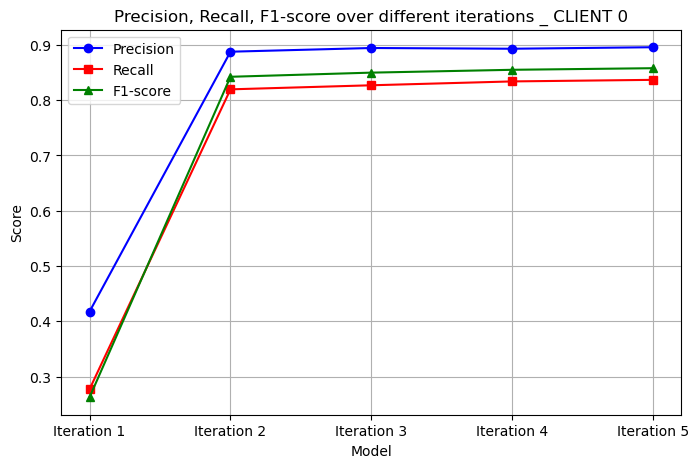

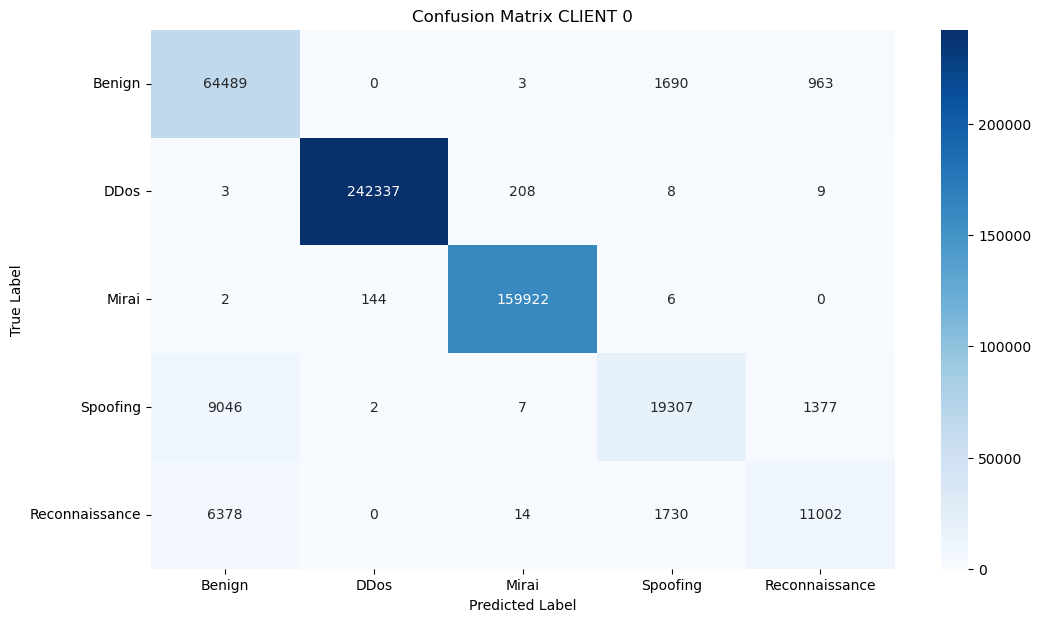

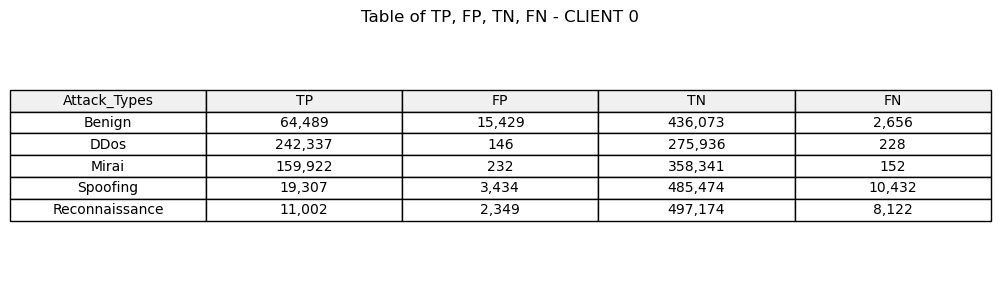

/tmp/ipykernel_48243/3454948976.py:125: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=8)


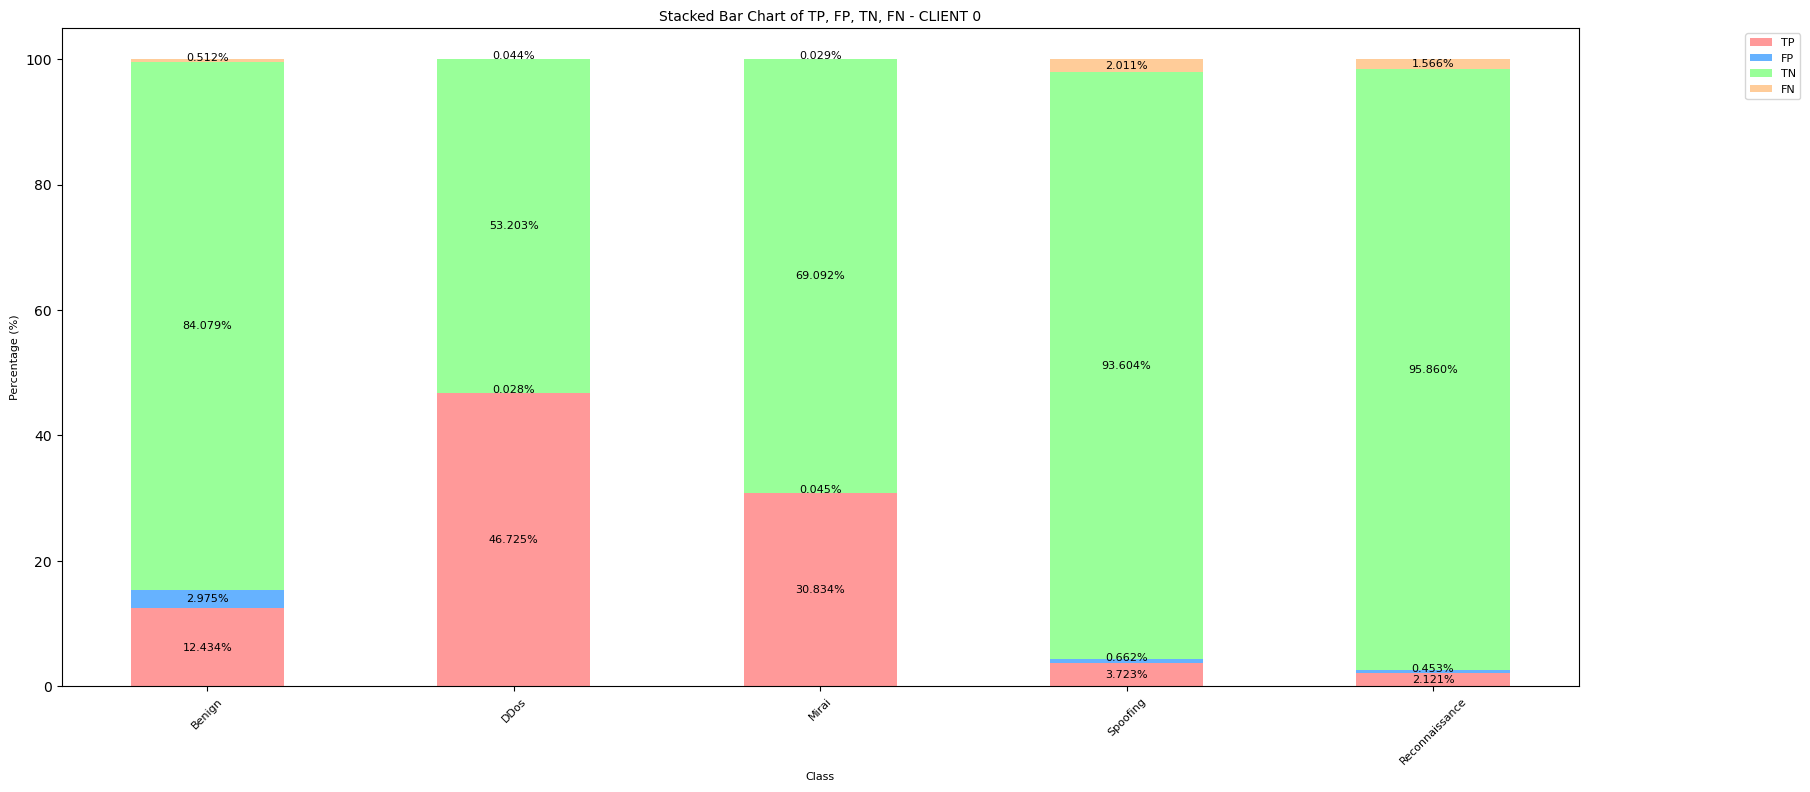

In [20]:
# Client 0
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
precisions = []
recalls = []
f1s = []

Iterations = [f"Iteration {index+1}" for index in range(5)]

X_test = []
y_test = []
for X_batch, y_batch in test_gens[0].take(stepsTest_Clients[0]):
    X_test.append(X_batch.numpy())
    y_test.append(y_batch.numpy())
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(len(X_test))
for iteration in range(len(Iterations)):
    print(models['client_0'][iteration])
    y_pred_pre = models['client_0'][iteration].predict(X_test, verbose=1)
    y_pred = np.argmax(y_pred_pre, axis=1)
    
    precisions.append(precision_score(y_test, y_pred, average='macro'))
    recalls.append(recall_score(y_test, y_pred, average='macro'))
    f1s.append(f1_score(y_test, y_pred, average='macro'))
print("Precision Score: ", precisions)
print("Recall Score: ", recalls)
print("F1 Score: ", f1s)  


# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(Iterations, precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations, recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations, f1s, marker='^', linestyle='-', label="F1-score", color='green')

# Thêm tiêu đề và nhãn
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 0")
plt.legend()
plt.grid(True)

# Hiển thị đồ thị
plt.savefig(tempdirs[0]+ "/pre_recall_f1.png", dpi=300, bbox_inches="tight")
plt.show()


attack_types =['Benign', 'DDos', 'Mirai', 'Spoofing', 'Reconnaissance']
cm = confusion_matrix(y_test, y_pred)
    # Vẽ heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
plt.yticks(rotation=360)
# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CLIENT 0")

# Hiển thị
plt.savefig(tempdirs[0]+ "/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# Tính TP, FP, TN, FN
metrics = []
num_classes = len(attack_types)
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])

# Vẽ bảng
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis("off")
table_data = [[f"{x:,.0f}" if isinstance(x, (int, float)) else x for x in row] for row in df_metrics.values]
table = ax.table(cellText=table_data, colLabels=df_metrics.columns, loc="center", cellLoc="center",
                 colColours=["#f0f0f0"] * len(df_metrics.columns))
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
ax.set_title("Table of TP, FP, TN, FN - CLIENT 0", fontsize=12, pad=5)

plt.tight_layout(pad=1.0)
plt.savefig(tempdirs[0]+ "/table_tp_fp_tn_fn.png", dpi=300, bbox_inches="tight")
plt.show()

## Chuẩn hóa dữ liệu (tính tỷ lệ phần trăm)
df_metrics[["TP", "FP", "TN", "FN"]] = df_metrics[["TP", "FP", "TN", "FN"]].div(
    df_metrics[["TP", "FP", "TN", "FN"]].sum(axis=1), axis=0
) * 100

# Vẽ biểu đồ cột chồng với sửa lỗi vị trí nhãn
fig, ax = plt.subplots(figsize=(18, 8))  # Tăng kích thước để có không gian hơn
bottom = np.zeros(len(df_metrics))
colors = ["#FF9999", "#66B2FF", "#99FF99", "#FFCC99"]

for metric, color in zip(["TP", "FP", "TN", "FN"], colors):
    bars = ax.bar(df_metrics["Attack_Types"], df_metrics[metric], width=0.5, label=metric, bottom=bottom, color=color)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:
            # Đặt nhãn ở giữa phần hiện tại dựa trên bottom và height
            y_pos = bottom[i] + height / 2  # Căn giữa nhãn trong phần hiện tại
            if height < 1:
                y_pos += 0.5
            ax.text(bar.get_x() + bar.get_width() / 2, y_pos,
                    f'{height:.3f}%', ha="center", va="center", rotation=0,  # Chữ nằm ngang
                    fontsize=8, color="black")
    bottom += df_metrics[metric]  # Cập nhật bottom cho phần tiếp theo

ax.set_xlabel("Class", fontsize=8)
ax.set_ylabel("Percentage (%)", fontsize=8)
ax.set_title("Stacked Bar Chart of TP, FP, TN, FN - CLIENT 0", fontsize=10, pad=5)
ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=8)
ax.legend(loc="upper right", fontsize=8, bbox_to_anchor=(1.15, 1))

plt.tight_layout(pad=1.0)
plt.savefig(tempdirs[0]+ "/stacked_bar_chart_tp_fp_tn_fn.png", dpi=300, bbox_inches="tight")
plt.show()

362431
<Sequential name=sequential_1, built=True>
11326/11326 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
<Sequential name=sequential_1, built=True>
11326/11326 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
<Sequential name=sequential_1, built=True>
11326/11326 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
<Sequential name=sequential_1, built=True>
11326/11326 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
<Sequential name=sequential_1, built=True>
11326/11326 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
Precision Score:  [0.39367819675379145, 0.8891833908841205, 0.8911142842542521, 0.895857888760262, 0.8962791047640064]
Recall Score:  [0.3173712825893974, 0.820473308288814, 0.8302618816688874, 0.8329992797451256, 0.8368316607090381]
F1 Score:  [0.26206838814909567, 0.8430795780775723, 0.8514023797920448, 0.8548281304019285, 0.8579309643555062]


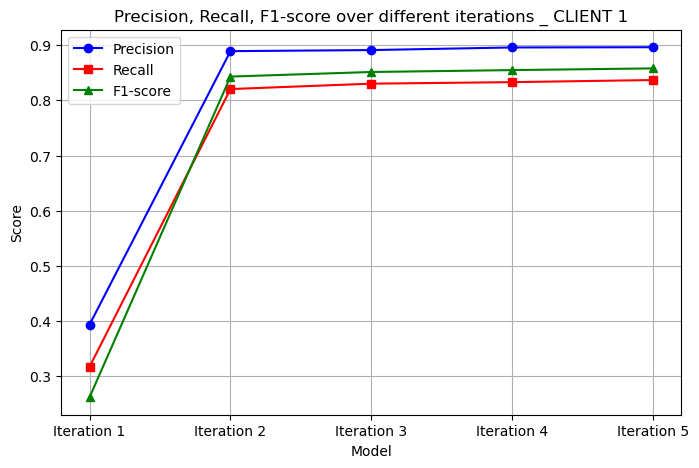

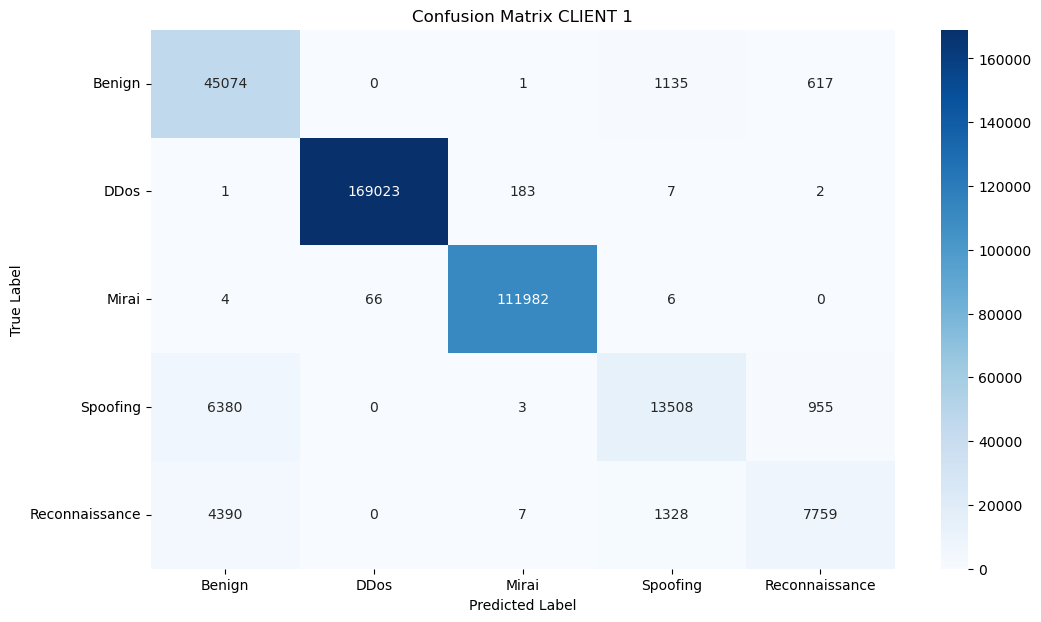

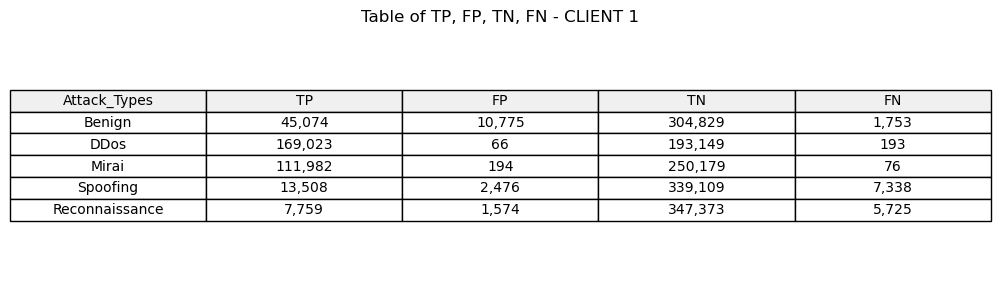

/tmp/ipykernel_48243/3445501142.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=8)


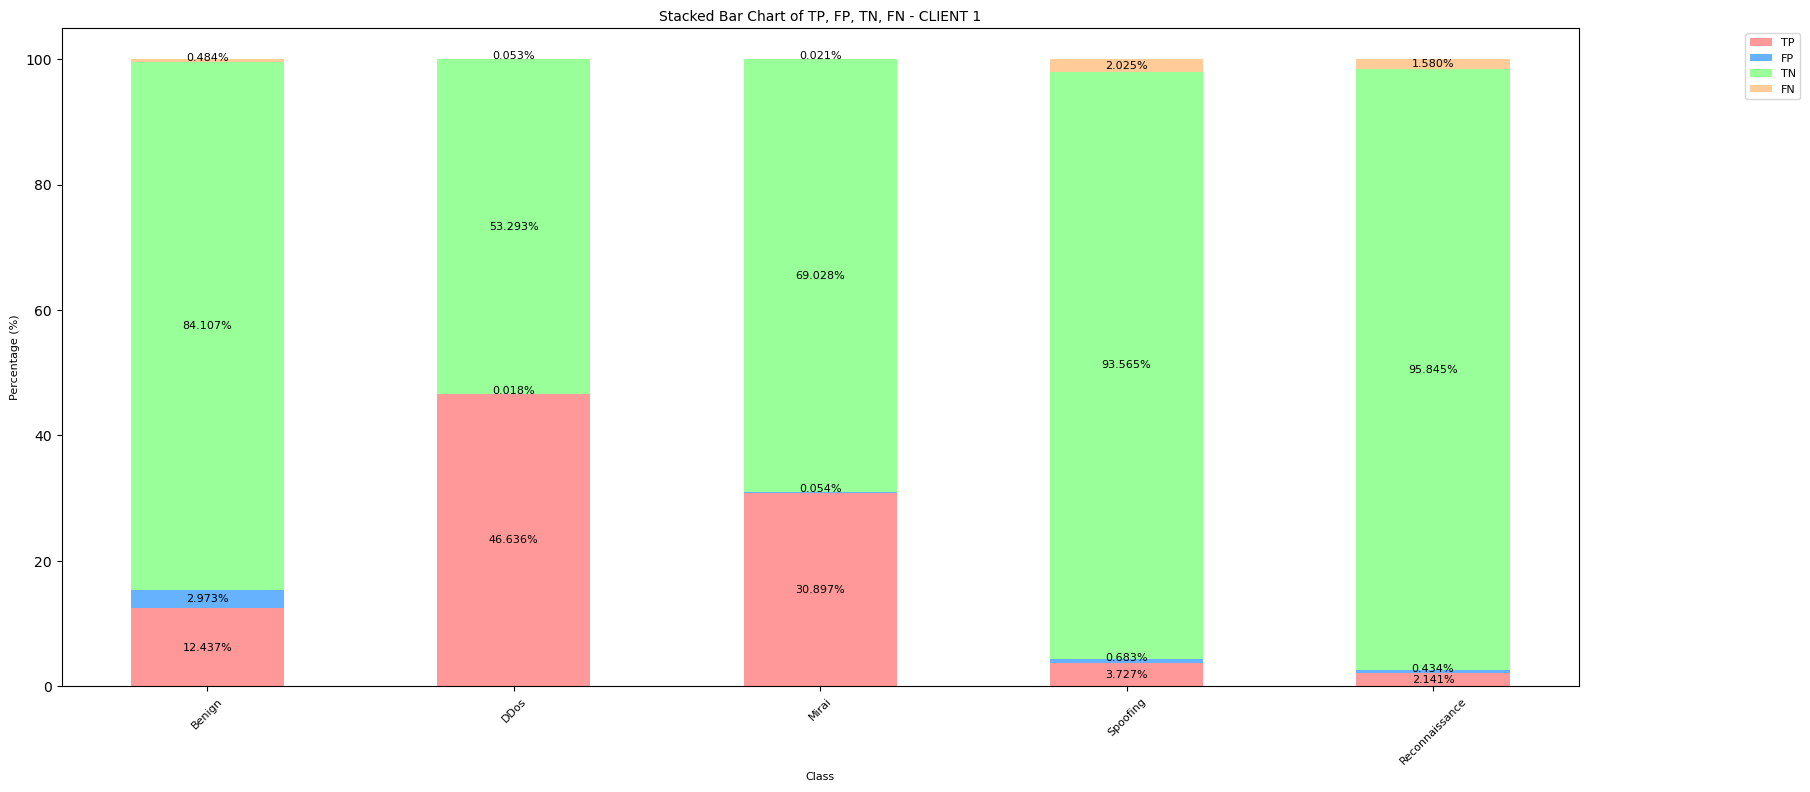

In [21]:
#Client 1

precisions = []
recalls = []
f1s = []

Iterations = [f"Iteration {index+1}" for index in range(5)]

X_test = []
y_test = []
for X_batch, y_batch in test_gens[1].take(stepsTest_Clients[1]):
    X_test.append(X_batch.numpy())
    y_test.append(y_batch.numpy())
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(len(X_test))
for iteration in range(len(Iterations)):
    print(models['client_1'][iteration])
    y_pred_pre = models['client_1'][iteration].predict(X_test, verbose=1)
    y_pred = np.argmax(y_pred_pre, axis=1)
    
    precisions.append(precision_score(y_test, y_pred, average='macro'))
    recalls.append(recall_score(y_test, y_pred, average='macro'))
    f1s.append(f1_score(y_test, y_pred, average='macro'))
print("Precision Score: ", precisions)
print("Recall Score: ", recalls)
print("F1 Score: ", f1s)  


# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(Iterations, precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations, recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations, f1s, marker='^', linestyle='-', label="F1-score", color='green')

# Thêm tiêu đề và nhãn
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 1")
plt.legend()
plt.grid(True)

# Hiển thị đồ thị
plt.savefig(tempdirs[1]+ "/pre_recall_f1.png", dpi=300, bbox_inches="tight")
plt.show()


attack_types =['Benign', 'DDos', 'Mirai', 'Spoofing', 'Reconnaissance']
cm = confusion_matrix(y_test, y_pred)
    # Vẽ heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
plt.yticks(rotation=360)
# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CLIENT 1")

# Hiển thị
plt.savefig(tempdirs[1]+ "/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# Tính TP, FP, TN, FN
metrics = []
num_classes = len(attack_types)
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])

# Vẽ bảng
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis("off")
table_data = [[f"{x:,.0f}" if isinstance(x, (int, float)) else x for x in row] for row in df_metrics.values]
table = ax.table(cellText=table_data, colLabels=df_metrics.columns, loc="center", cellLoc="center",
                 colColours=["#f0f0f0"] * len(df_metrics.columns))
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
ax.set_title("Table of TP, FP, TN, FN - CLIENT 1", fontsize=12, pad=5)

plt.tight_layout(pad=1.0)
plt.savefig(tempdirs[1]+ "/table_tp_fp_tn_fn.png", dpi=300, bbox_inches="tight")
plt.show()

## Chuẩn hóa dữ liệu (tính tỷ lệ phần trăm)
df_metrics[["TP", "FP", "TN", "FN"]] = df_metrics[["TP", "FP", "TN", "FN"]].div(
    df_metrics[["TP", "FP", "TN", "FN"]].sum(axis=1), axis=0
) * 100

# Vẽ biểu đồ cột chồng với sửa lỗi vị trí nhãn
fig, ax = plt.subplots(figsize=(18, 8))  # Tăng kích thước để có không gian hơn
bottom = np.zeros(len(df_metrics))
colors = ["#FF9999", "#66B2FF", "#99FF99", "#FFCC99"]

for metric, color in zip(["TP", "FP", "TN", "FN"], colors):
    bars = ax.bar(df_metrics["Attack_Types"], df_metrics[metric], width=0.5, label=metric, bottom=bottom, color=color)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:
            # Đặt nhãn ở giữa phần hiện tại dựa trên bottom và height
            y_pos = bottom[i] + height / 2  # Căn giữa nhãn trong phần hiện tại
            if height < 1:
                y_pos += 0.5
            ax.text(bar.get_x() + bar.get_width() / 2, y_pos,
                    f'{height:.3f}%', ha="center", va="center", rotation=0,  # Chữ nằm ngang
                    fontsize=8, color="black")
    bottom += df_metrics[metric]  # Cập nhật bottom cho phần tiếp theo

ax.set_xlabel("Class", fontsize=8)
ax.set_ylabel("Percentage (%)", fontsize=8)
ax.set_title("Stacked Bar Chart of TP, FP, TN, FN - CLIENT 1", fontsize=10, pad=5)
ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=8)
ax.legend(loc="upper right", fontsize=8, bbox_to_anchor=(1.15, 1))

plt.tight_layout(pad=1.0)
plt.savefig(tempdirs[1]+ "/stacked_bar_chart_tp_fp_tn_fn.png", dpi=300, bbox_inches="tight")
plt.show()

412290
<Sequential name=sequential_2, built=True>
12873/12885 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-06-24 13:45:53.153163: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 128 bytes spill stores, 128 bytes spill loads

2025-06-24 13:45:53.197464: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 384 bytes spill stores, 384 bytes spill loads



12885/12885 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
<Sequential name=sequential_2, built=True>
12885/12885 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
<Sequential name=sequential_2, built=True>
12885/12885 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
<Sequential name=sequential_2, built=True>
12885/12885 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
<Sequential name=sequential_2, built=True>
12885/12885 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
Precision Score:  [0.5100404040103802, 0.8883508830319806, 0.8929460231316593, 0.8999024998467036, 0.9001539997103212]
Recall Score:  [0.41660971594970153, 0.8155522585911431, 0.8237842875943266, 0.8243774467566913, 0.8308055147200919]
F1 Score:  [0.39730736790407173, 0.8389324016485853, 0.8466674987579779, 0.8488346367750411, 0.8541185562638894]


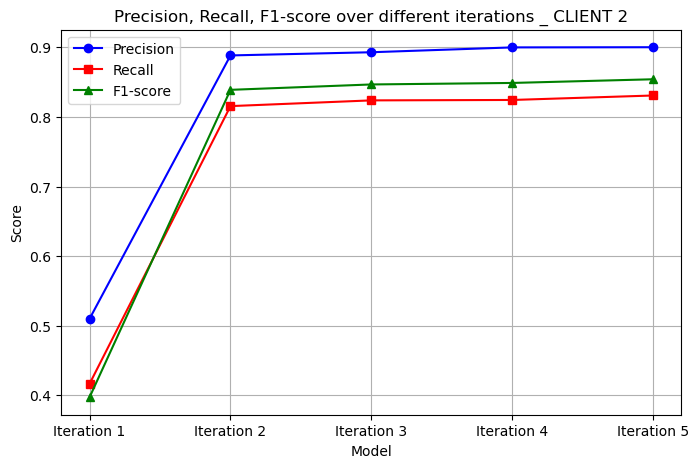

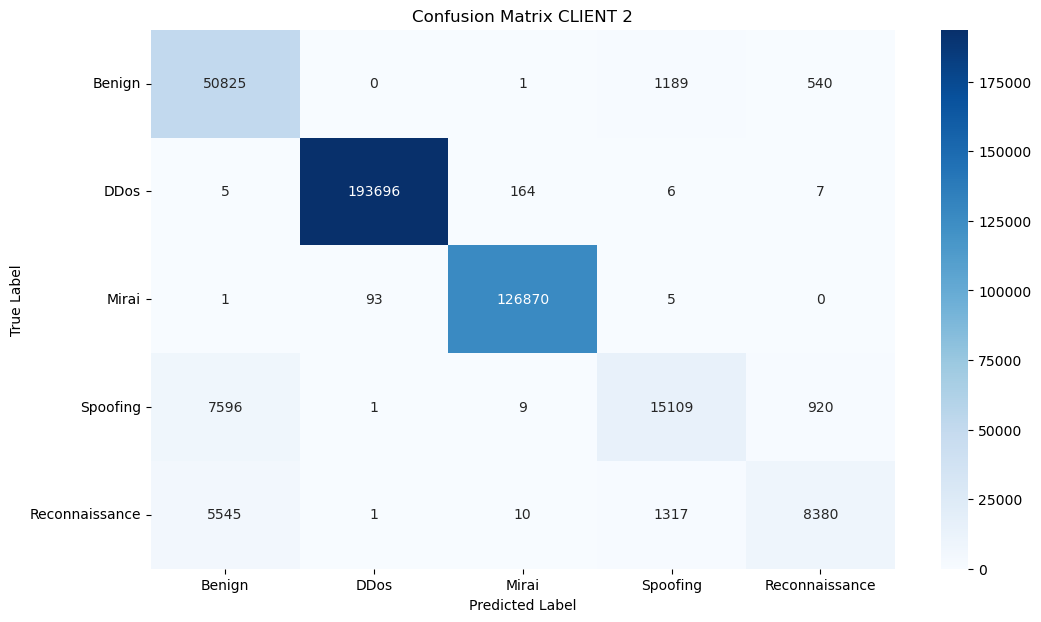

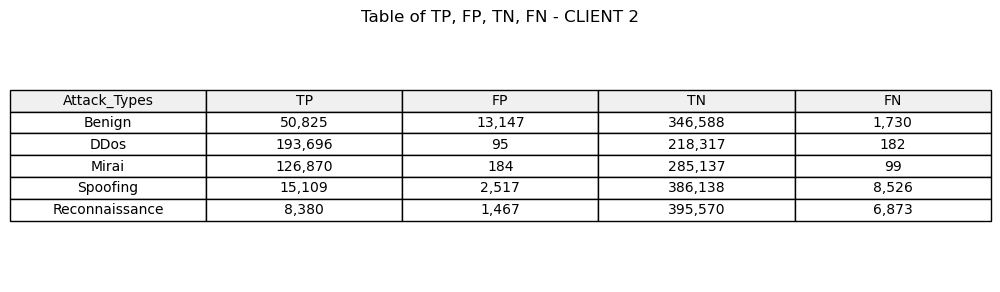

/tmp/ipykernel_48243/3939820580.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=8)


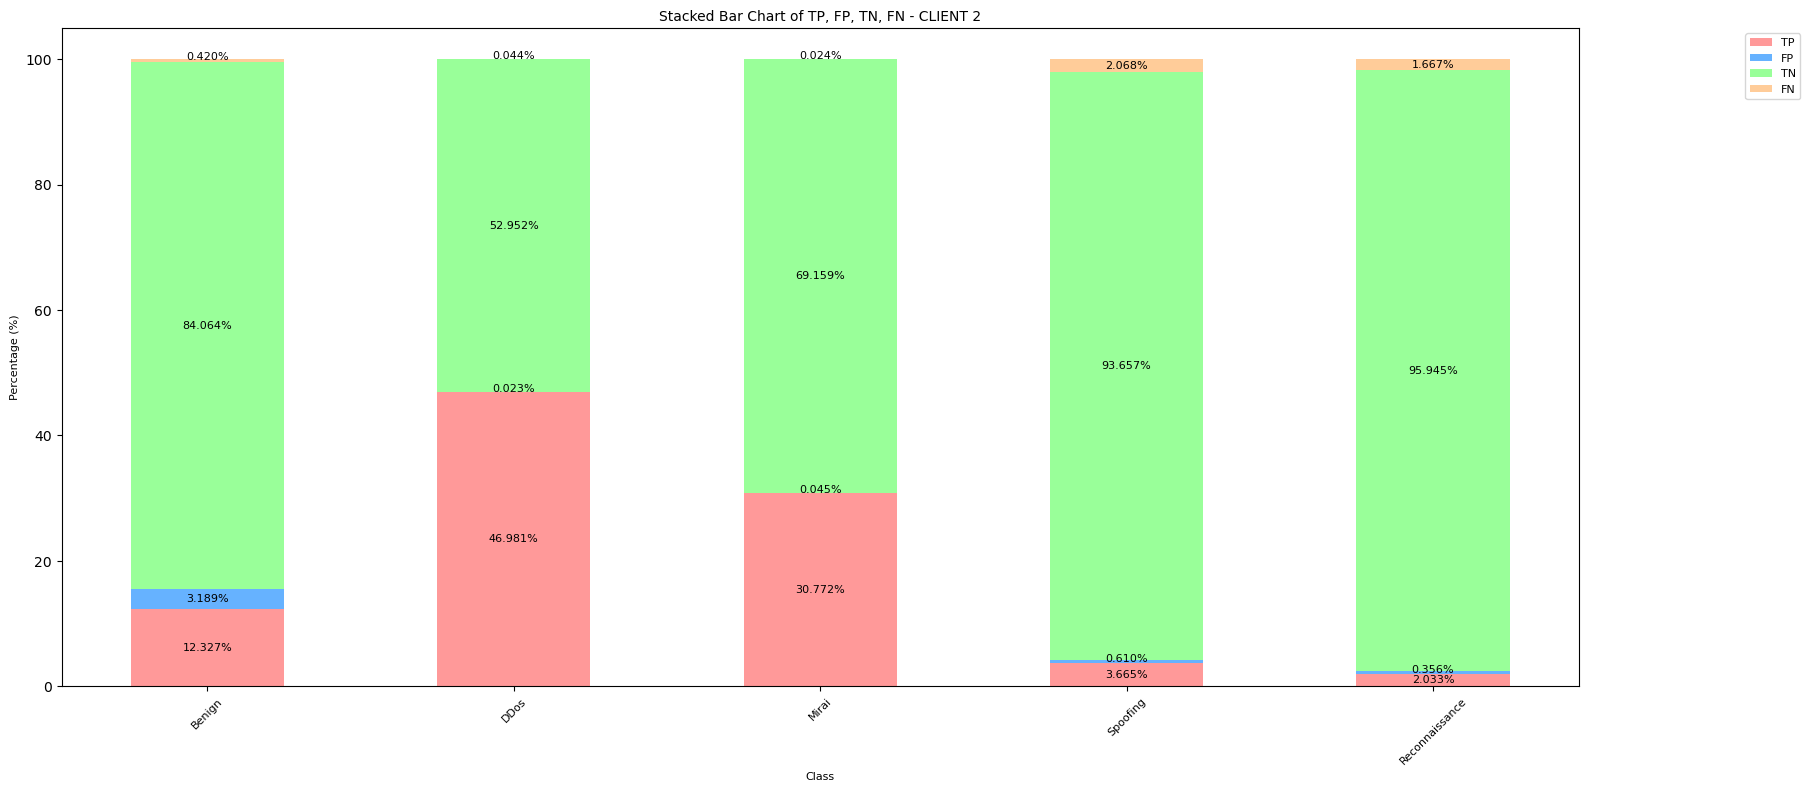

In [22]:
#Client 2

precisions = []
recalls = []
f1s = []

Iterations = [f"Iteration {index+1}" for index in range(5)]

X_test = []
y_test = []
for X_batch, y_batch in test_gens[2].take(stepsTest_Clients[2]):
    X_test.append(X_batch.numpy())
    y_test.append(y_batch.numpy())
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(len(X_test))
for iteration in range(len(Iterations)):
    print(models['client_2'][iteration])
    y_pred_pre = models['client_2'][iteration].predict(X_test, verbose=1)
    y_pred = np.argmax(y_pred_pre, axis=1)
    
    precisions.append(precision_score(y_test, y_pred, average='macro'))
    recalls.append(recall_score(y_test, y_pred, average='macro'))
    f1s.append(f1_score(y_test, y_pred, average='macro'))
print("Precision Score: ", precisions)
print("Recall Score: ", recalls)
print("F1 Score: ", f1s)  


# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(Iterations, precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations, recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations, f1s, marker='^', linestyle='-', label="F1-score", color='green')

# Thêm tiêu đề và nhãn
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 2")
plt.legend()
plt.grid(True)

# Hiển thị đồ thị
plt.savefig(tempdirs[2]+ "/pre_recall_f1.png", dpi=300, bbox_inches="tight")
plt.show()


attack_types =['Benign', 'DDos', 'Mirai', 'Spoofing', 'Reconnaissance']
cm = confusion_matrix(y_test, y_pred)
    # Vẽ heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
plt.yticks(rotation=360)
# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CLIENT 2")

# Hiển thị
plt.savefig(tempdirs[2]+ "/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# Tính TP, FP, TN, FN
metrics = []
num_classes = len(attack_types)
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])

# Vẽ bảng
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis("off")
table_data = [[f"{x:,.0f}" if isinstance(x, (int, float)) else x for x in row] for row in df_metrics.values]
table = ax.table(cellText=table_data, colLabels=df_metrics.columns, loc="center", cellLoc="center",
                 colColours=["#f0f0f0"] * len(df_metrics.columns))
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
ax.set_title("Table of TP, FP, TN, FN - CLIENT 2", fontsize=12, pad=5)

plt.tight_layout(pad=1.0)
plt.savefig(tempdirs[2]+ "/table_tp_fp_tn_fn.png", dpi=300, bbox_inches="tight")
plt.show()

## Chuẩn hóa dữ liệu (tính tỷ lệ phần trăm)
df_metrics[["TP", "FP", "TN", "FN"]] = df_metrics[["TP", "FP", "TN", "FN"]].div(
    df_metrics[["TP", "FP", "TN", "FN"]].sum(axis=1), axis=0
) * 100

# Vẽ biểu đồ cột chồng với sửa lỗi vị trí nhãn
fig, ax = plt.subplots(figsize=(18, 8))  # Tăng kích thước để có không gian hơn
bottom = np.zeros(len(df_metrics))
colors = ["#FF9999", "#66B2FF", "#99FF99", "#FFCC99"]

for metric, color in zip(["TP", "FP", "TN", "FN"], colors):
    bars = ax.bar(df_metrics["Attack_Types"], df_metrics[metric], width=0.5, label=metric, bottom=bottom, color=color)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:
            # Đặt nhãn ở giữa phần hiện tại dựa trên bottom và height
            y_pos = bottom[i] + height / 2  # Căn giữa nhãn trong phần hiện tại
            if height < 1:
                y_pos += 0.5
            ax.text(bar.get_x() + bar.get_width() / 2, y_pos,
                    f'{height:.3f}%', ha="center", va="center", rotation=0,  # Chữ nằm ngang
                    fontsize=8, color="black")
    bottom += df_metrics[metric]  # Cập nhật bottom cho phần tiếp theo

ax.set_xlabel("Class", fontsize=8)
ax.set_ylabel("Percentage (%)", fontsize=8)
ax.set_title("Stacked Bar Chart of TP, FP, TN, FN - CLIENT 2", fontsize=10, pad=5)
ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=8)
ax.legend(loc="upper right", fontsize=8, bbox_to_anchor=(1.15, 1))

plt.tight_layout(pad=1.0)
plt.savefig(tempdirs[2]+ "/stacked_bar_chart_tp_fp_tn_fn.png", dpi=300, bbox_inches="tight")
plt.show()

['Iteration_1.csv', 'Iteration_2.csv', 'Iteration_3.csv', 'Iteration_4.csv', 'Iteration_5.csv']


/tmp/ipykernel_48243/1593781560.py:92: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


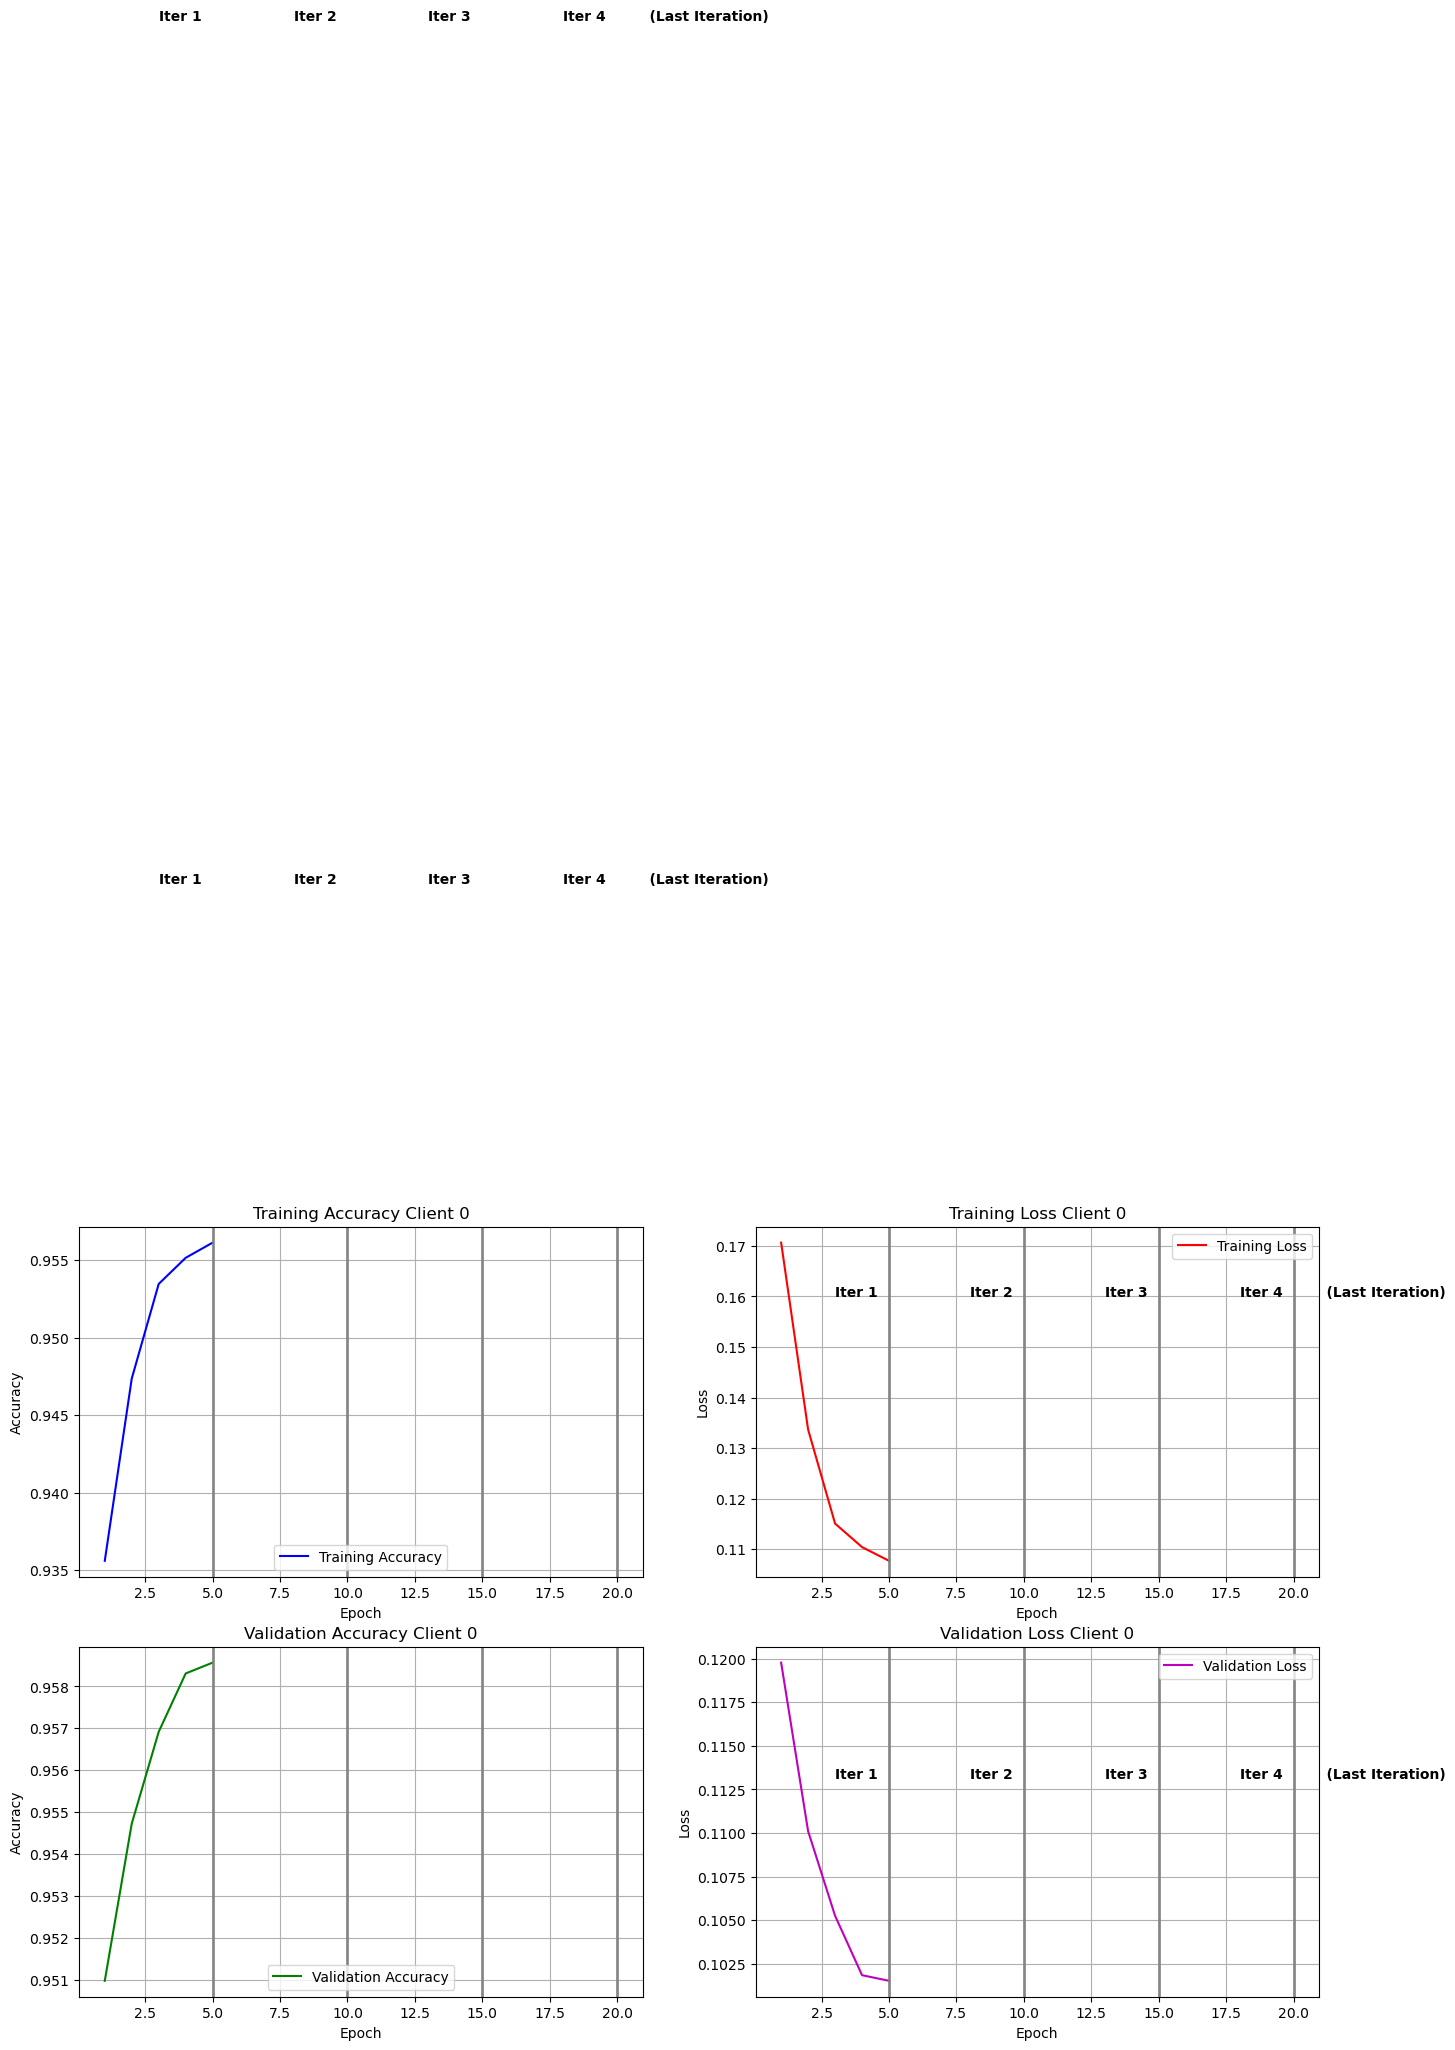

/tmp/ipykernel_48243/1593781560.py:92: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


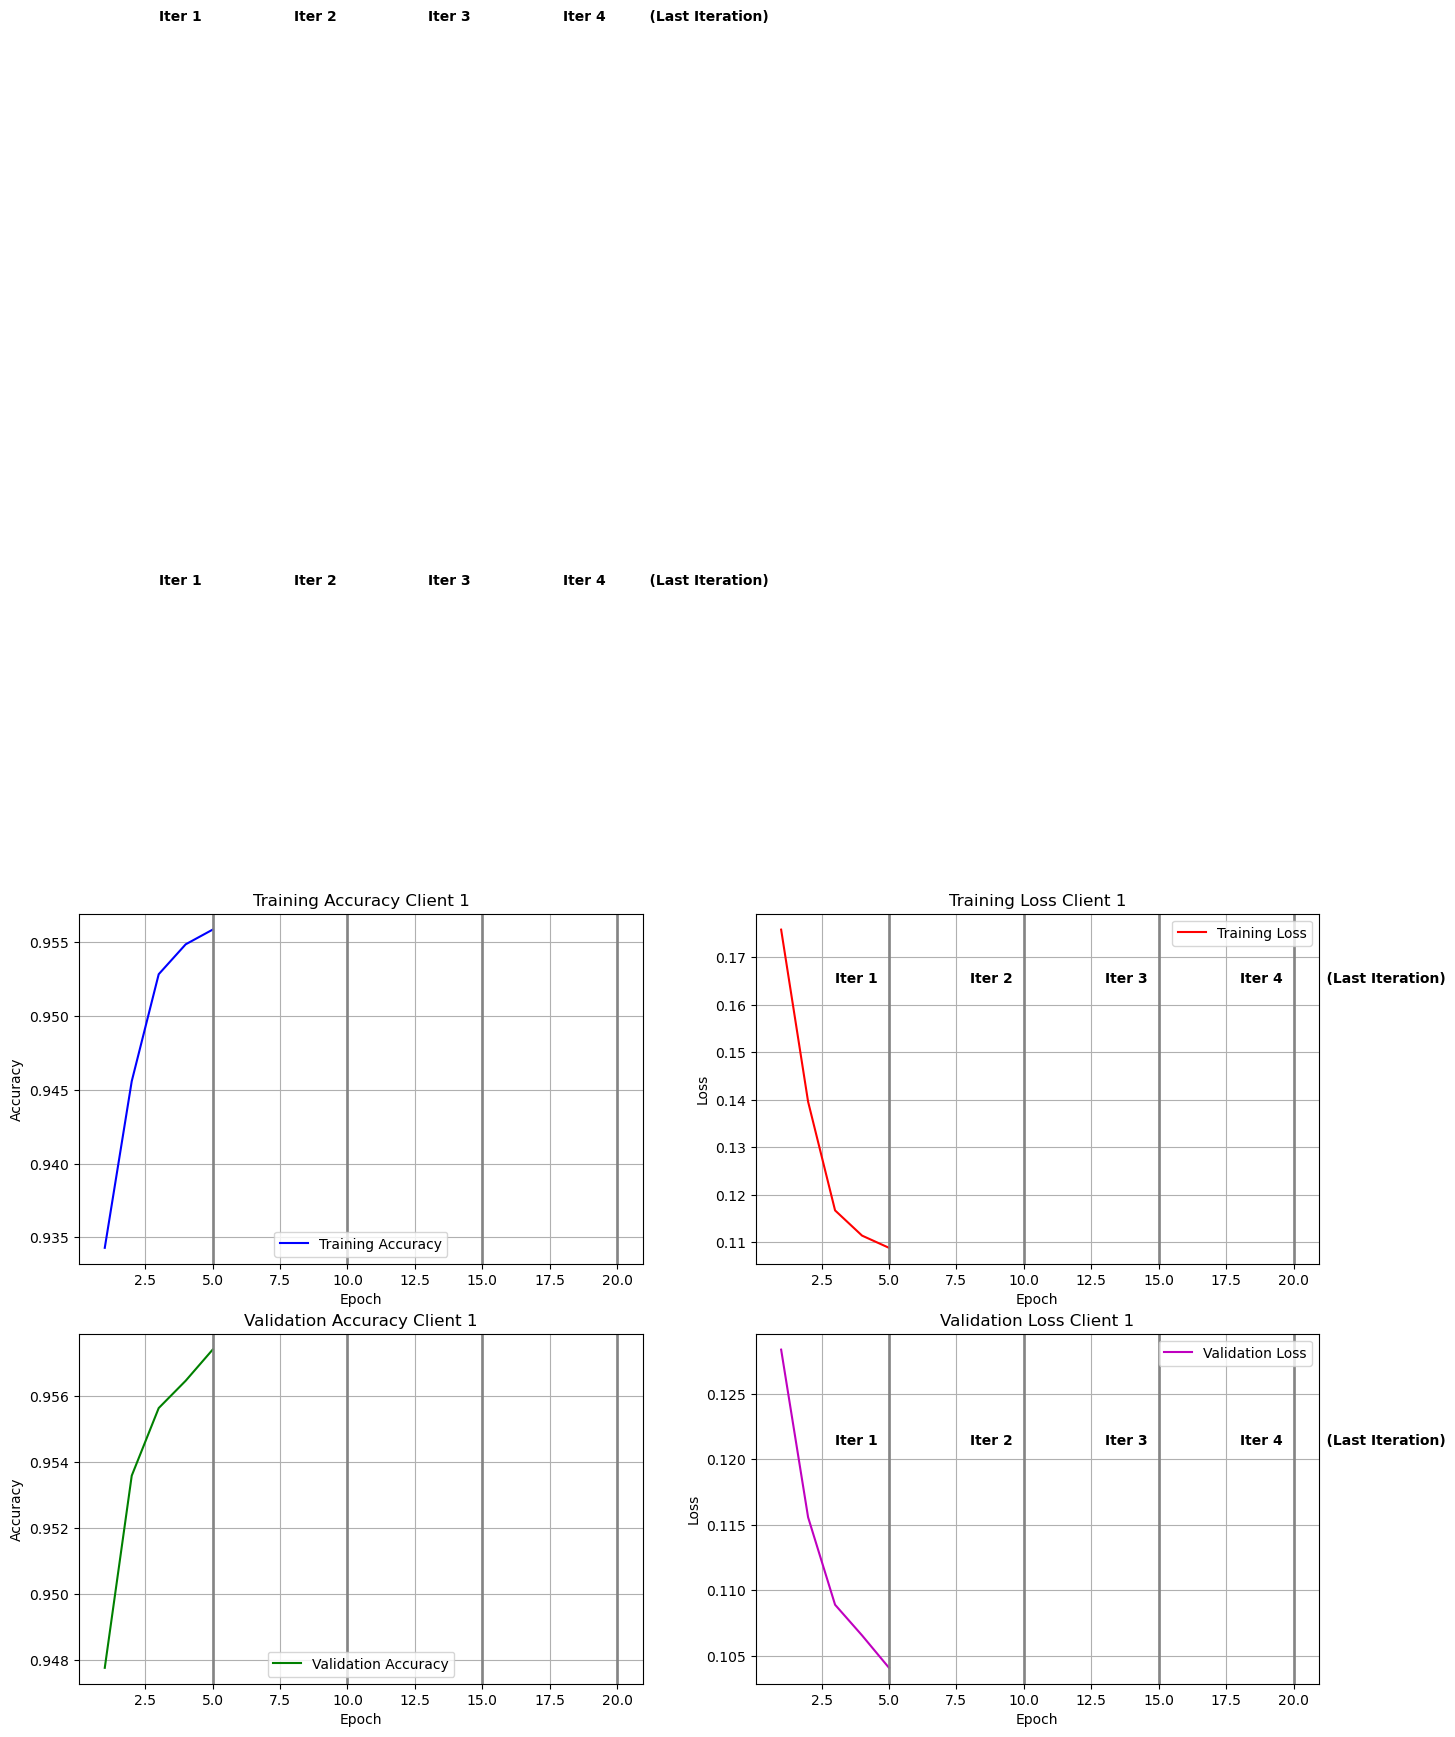

/tmp/ipykernel_48243/1593781560.py:92: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


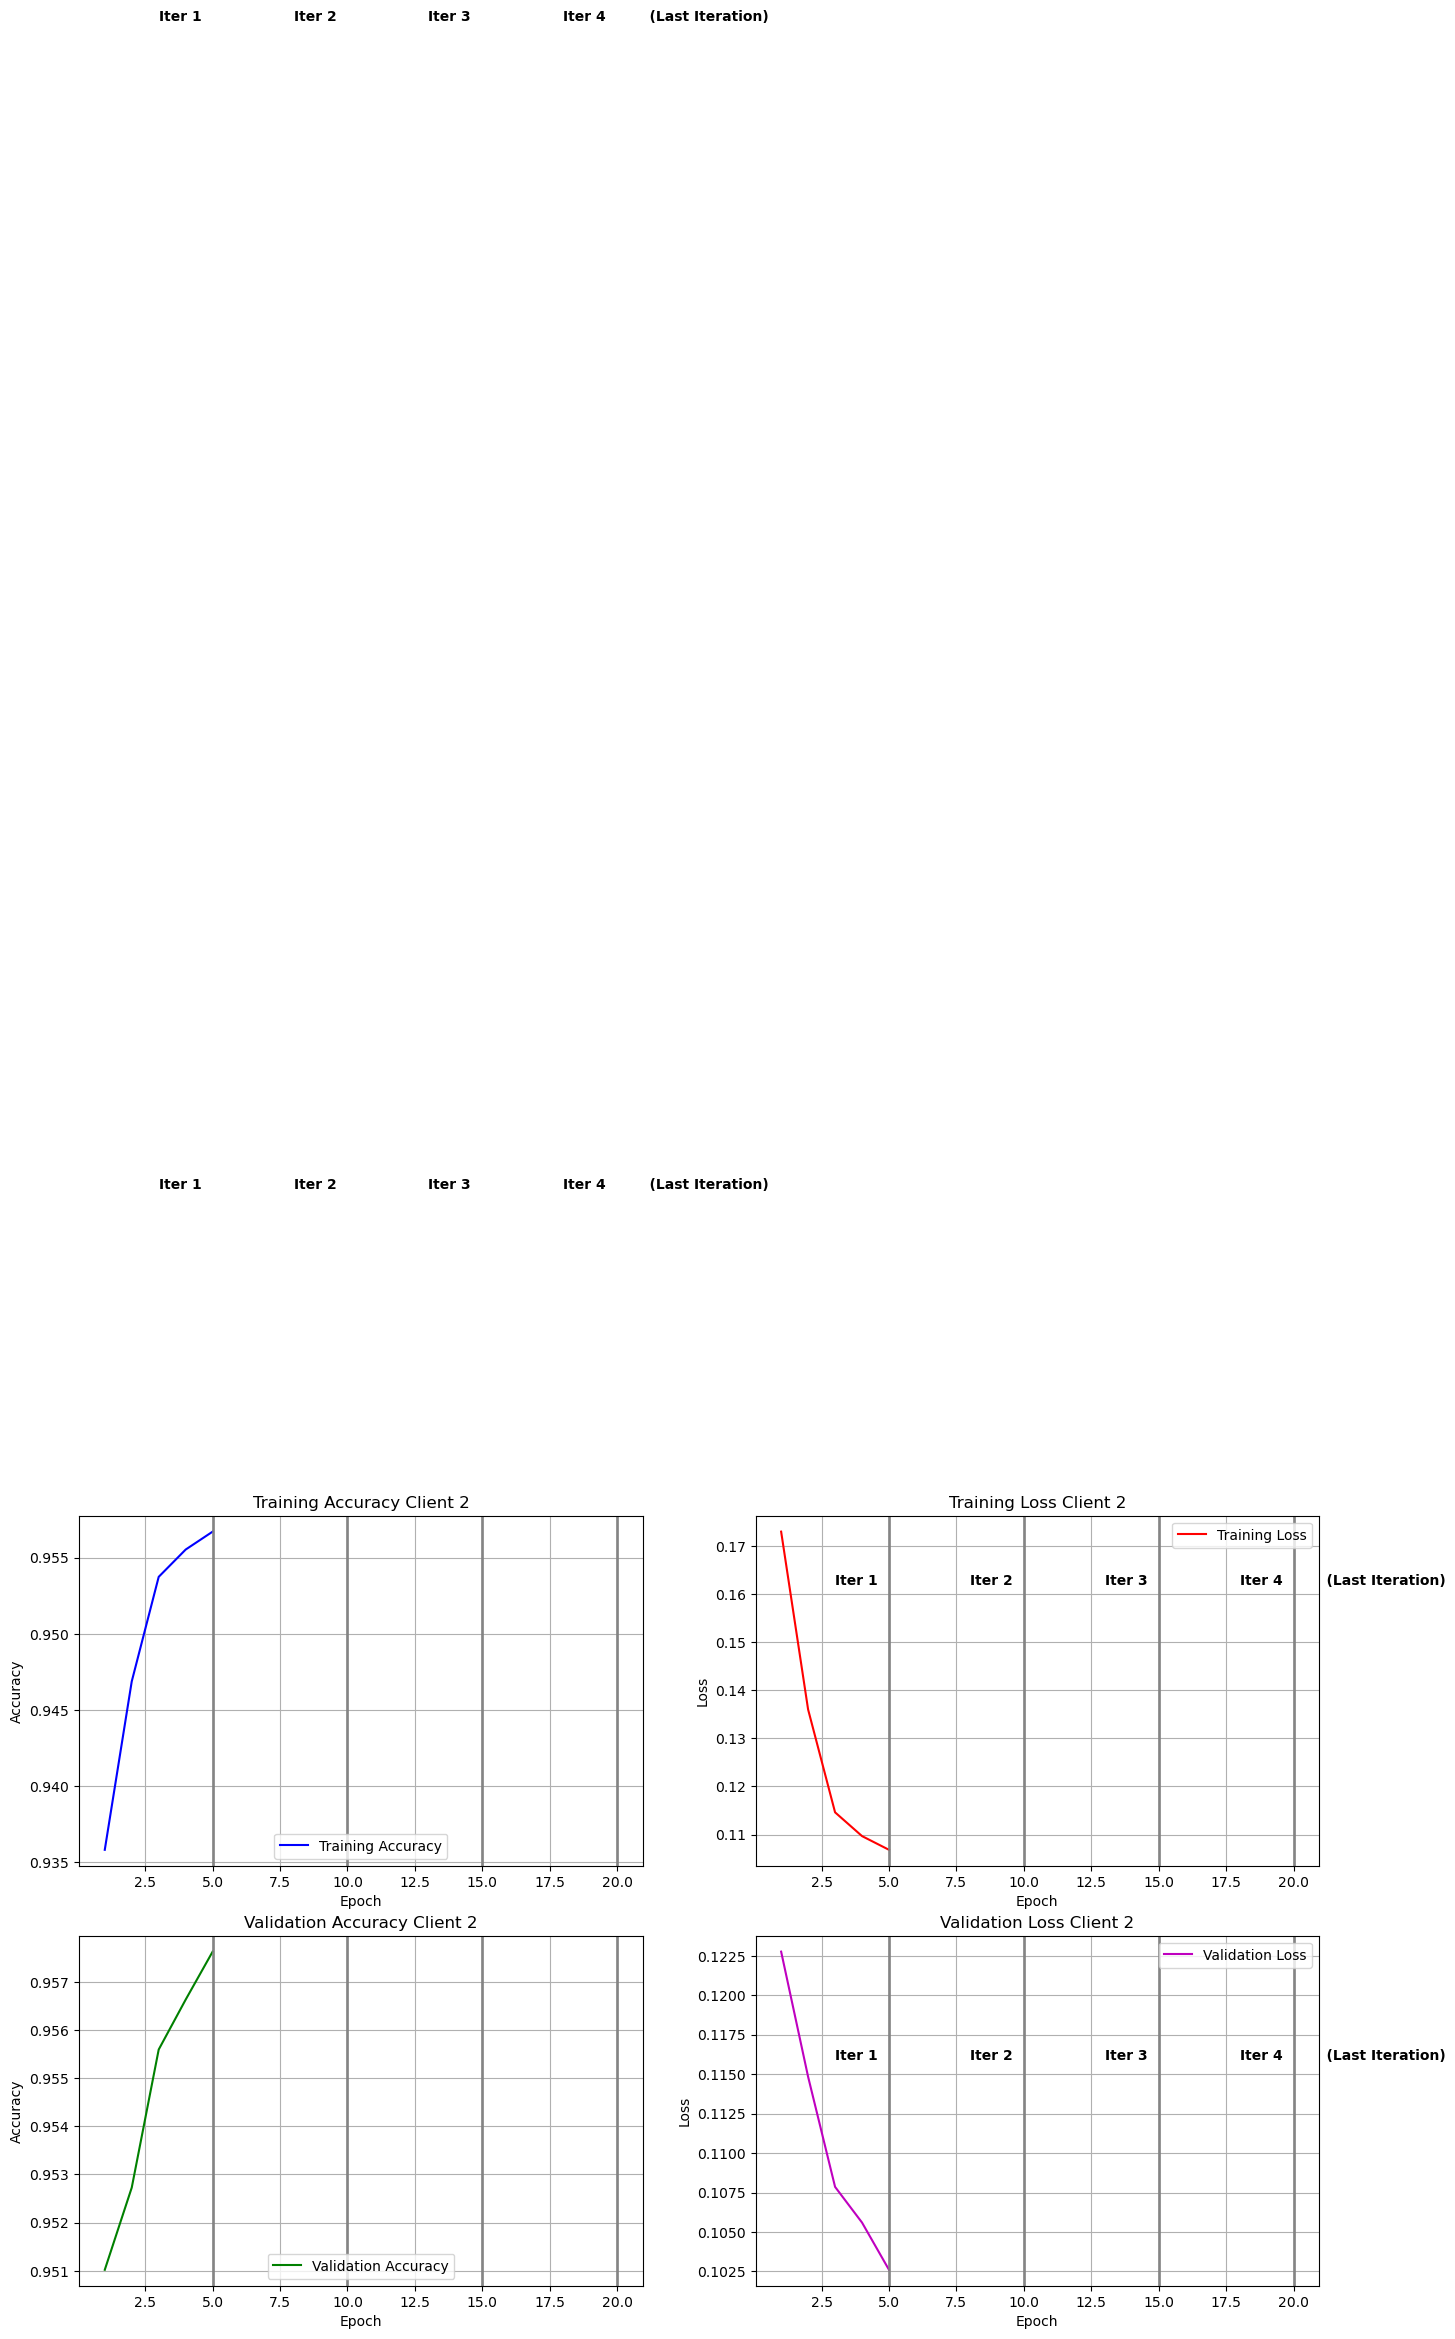

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Giả định tempdirs đã được định nghĩa
# Ví dụ: tempdirs = [f"federated_learning_log/21h-04p-Month05-Day27/client_{i}_log/" for i in range(4)]
#tempdirs = [f"multiclass_FL_log/Month06-Day24-12h-18p/client_{i}_log/" for i in range(3)]  # 3 clients
log_names = [f"Iteration_{i+1}.csv" for i in range(5)]
print(log_names)

# Vẽ biểu đồ cho từng client
for i in range(3):
    # Kết hợp dữ liệu từ các file log
    all_logs = []
    for log_name in log_names:
        file_path = tempdirs[i] + log_name
        if not os.path.exists(file_path):
            print(f"File {file_path} không tồn tại!")
            continue
        log_part = pd.read_csv(file_path)
        all_logs.append(log_part)

    # Kết hợp dữ liệu từ các file log
    log_df = pd.concat(all_logs, ignore_index=True)
    epochs = range(1, len(log_df) + 1)  # Tổng cộng 20 epoch (4 iterations x 5 epochs)

    plt.figure(figsize=(16, 10))

    # Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs, log_df['accuracy'], 'b-', label='Training Accuracy')
    # Thêm đường kẻ dọc tại epoch 5, 10, 15
    for iter_idx in range(1, len(log_names)):
        plt.axvline(x=iter_idx * 5, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        if iter_idx < len(log_names) - 1:  
            plt.text(iter_idx * 5 - 2, 0.98, f'Iter {iter_idx}', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
        else:  # Iter 4
            plt.text(iter_idx * 5 - 2, 0.98, f'Iter {iter_idx}         (Last Iteration)', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
    plt.title(f'Training Accuracy Client {i}')
    plt.title(f'Training Accuracy Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, log_df['loss'], 'r-', label='Training Loss')
    for iter_idx in range(1, len(log_names)):
        plt.axvline(x=iter_idx * 5, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        if iter_idx < len(log_names) - 1:
            plt.text(iter_idx * 5 - 2, max(log_df['loss']) * 0.95, f'Iter {iter_idx}', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
        else:
            plt.text(iter_idx * 5 - 2, max(log_df['loss']) * 0.95, f'Iter {iter_idx}         (Last Iteration)', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
    plt.title(f'Training Loss Client {i}')
    plt.title(f'Training Loss Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Validation Accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, log_df['val_accuracy'], 'g-', label='Validation Accuracy')
    for iter_idx in range(1, len(log_names)):
        plt.axvline(x=iter_idx * 5, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        if iter_idx < len(log_names) - 1:
            plt.text(iter_idx * 5 - 2, 0.998, f'Iter {iter_idx}', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
        else:
            plt.text(iter_idx * 5 - 2, 0.998, f'Iter {iter_idx}         (Last Iteration)', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
    plt.title(f'Validation Accuracy Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Validation Loss
    plt.subplot(2, 2, 4)
    plt.plot(epochs, log_df['val_loss'], 'm-', label='Validation Loss')
    for iter_idx in range(1, len(log_names)):
        plt.axvline(x=iter_idx * 5, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        if iter_idx < len(log_names) - 1:
            plt.text(iter_idx * 5 - 2, max(log_df['val_loss']) * 0.95, f'Iter {iter_idx}', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
        else:
            plt.text(iter_idx * 5 - 2, max(log_df['val_loss']) * 0.95, f'Iter {iter_idx}         (Last Iteration)', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
    plt.title(f'Validation Loss Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    #plt.savefig(tempdirs[i]+ "/train_valid_acc_loss.png", dpi=300, bbox_inches="tight")
    plt.show()

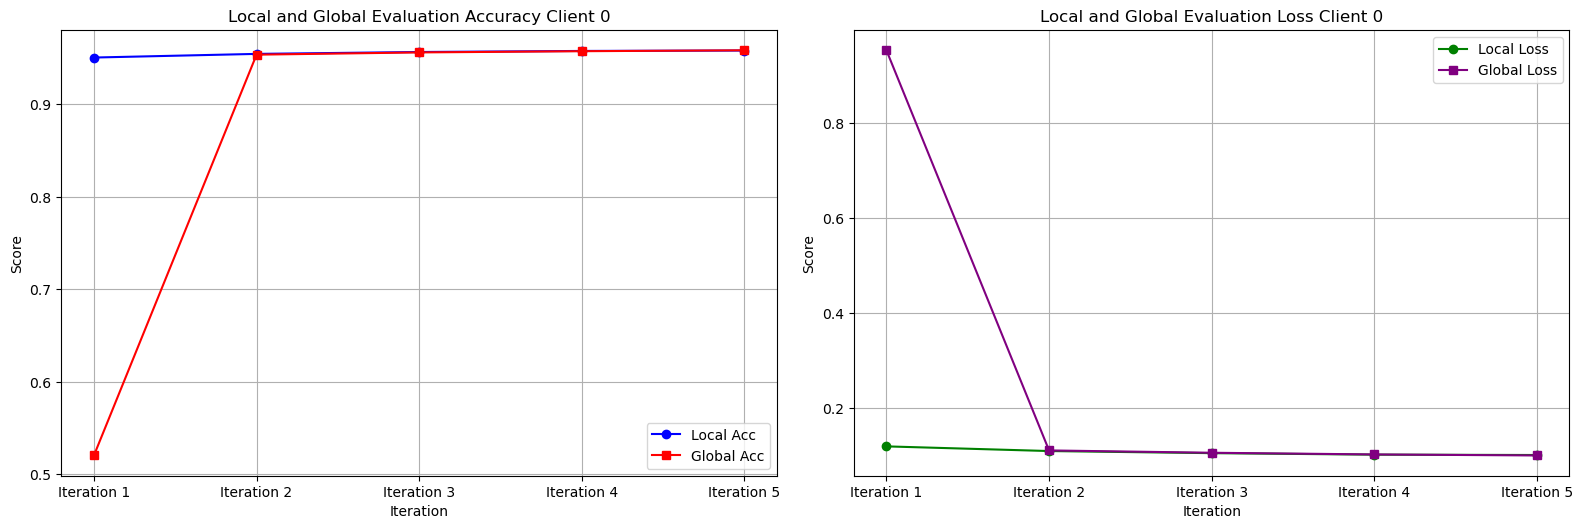

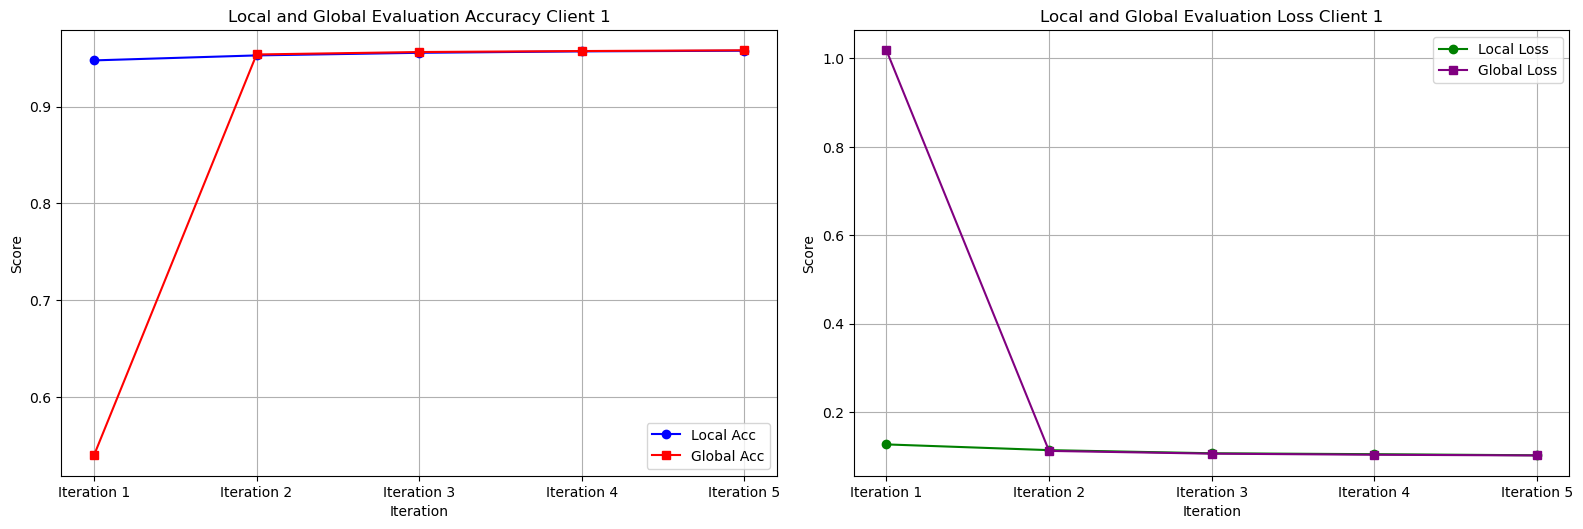

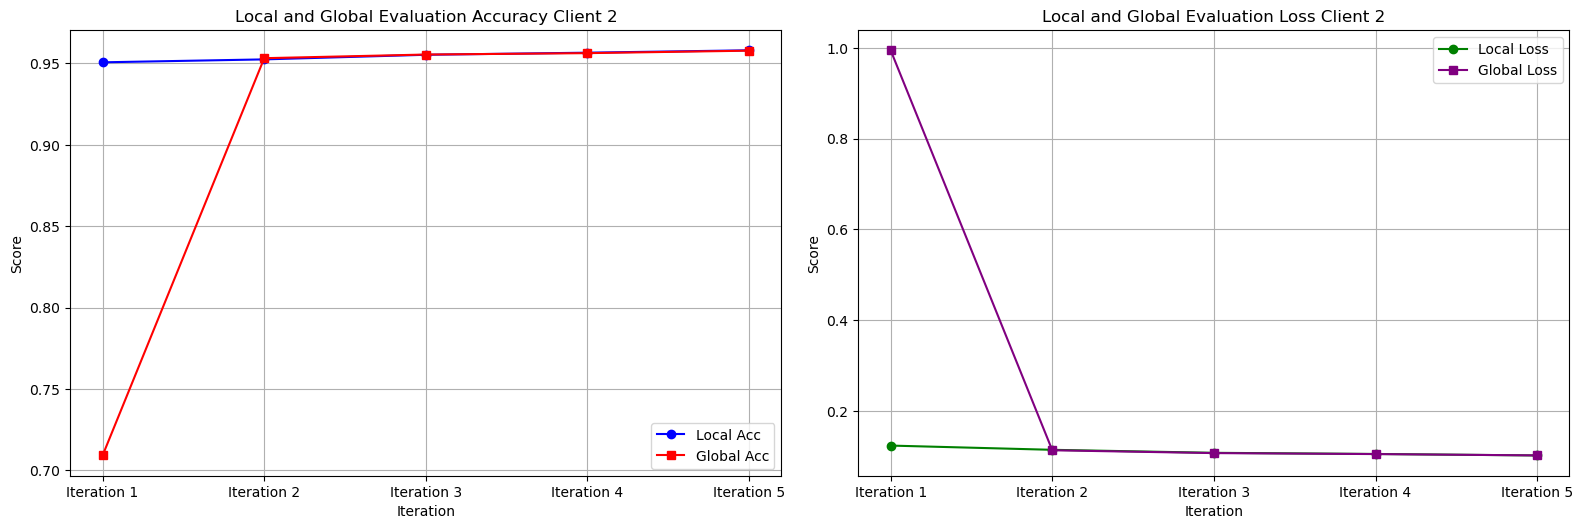

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Giả định tempdirs đã được định nghĩa
# Ví dụ: tempdirs = [f"federated_learning_log/21h-04p-Month05-Day27/client_{i}_log/" for i in range(4)]
#tempdirs = [f"federated_learning_log/Month05-Day27-18h-56p/client_{i}_log/" for i in range(4)]  # 4 clients
Iterations = [f"Iteration {index+1}" for index in range(5)]

# Vẽ biểu đồ cho từng client
for i in range(3):
    file_path_local = tempdirs[i] + "local_val.csv"
    file_path_global = tempdirs[i] + "global_val.csv"
  
    local_val = pd.read_csv(file_path_local)
    global_val = pd.read_csv(file_path_global)
    # Vẽ biểu đồ
    plt.figure(figsize=(16, 10))
    plt.subplot(2, 2, 1)
    plt.plot(Iterations, local_val['local_acc'], marker='o', linestyle='-', label="Local Acc", color='blue')
    plt.plot(Iterations, global_val['global_acc'], marker='s', linestyle='-', label="Global Acc", color='red')
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"Local and Global Evaluation Accuracy Client {i}")
    plt.legend()
    #plt.ylim(0.5, 1)  # Giới hạn từ 0 đến 1
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(Iterations, local_val['local_loss'], marker='o', linestyle='-', label="Local Loss", color='green')
    plt.plot(Iterations, global_val['global_loss'], marker='s', linestyle='-', label="Global Loss", color='purple')
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"Local and Global Evaluation Loss Client {i}")
    plt.legend()
    #plt.ylim(0.5, 1)  # Giới hạn từ 0 đến 1
    plt.grid(True)

    plt.tight_layout()
    # Hiển thị đồ thị
    plt.savefig(tempdirs[i]+ "/evaluation_acc_loss.png", dpi=300, bbox_inches="tight")
    plt.show()